In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.plot_trials import plot_trials
from ephysvibe.stats import smetrics

In [14]:
path='//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/2022-11-22_10-59-03_Riesling_pfc_e1_r1_mua19_neu.h5'
neu = NeuronData.from_python_hdf5(path)
nid = neu.get_neuron_id() 

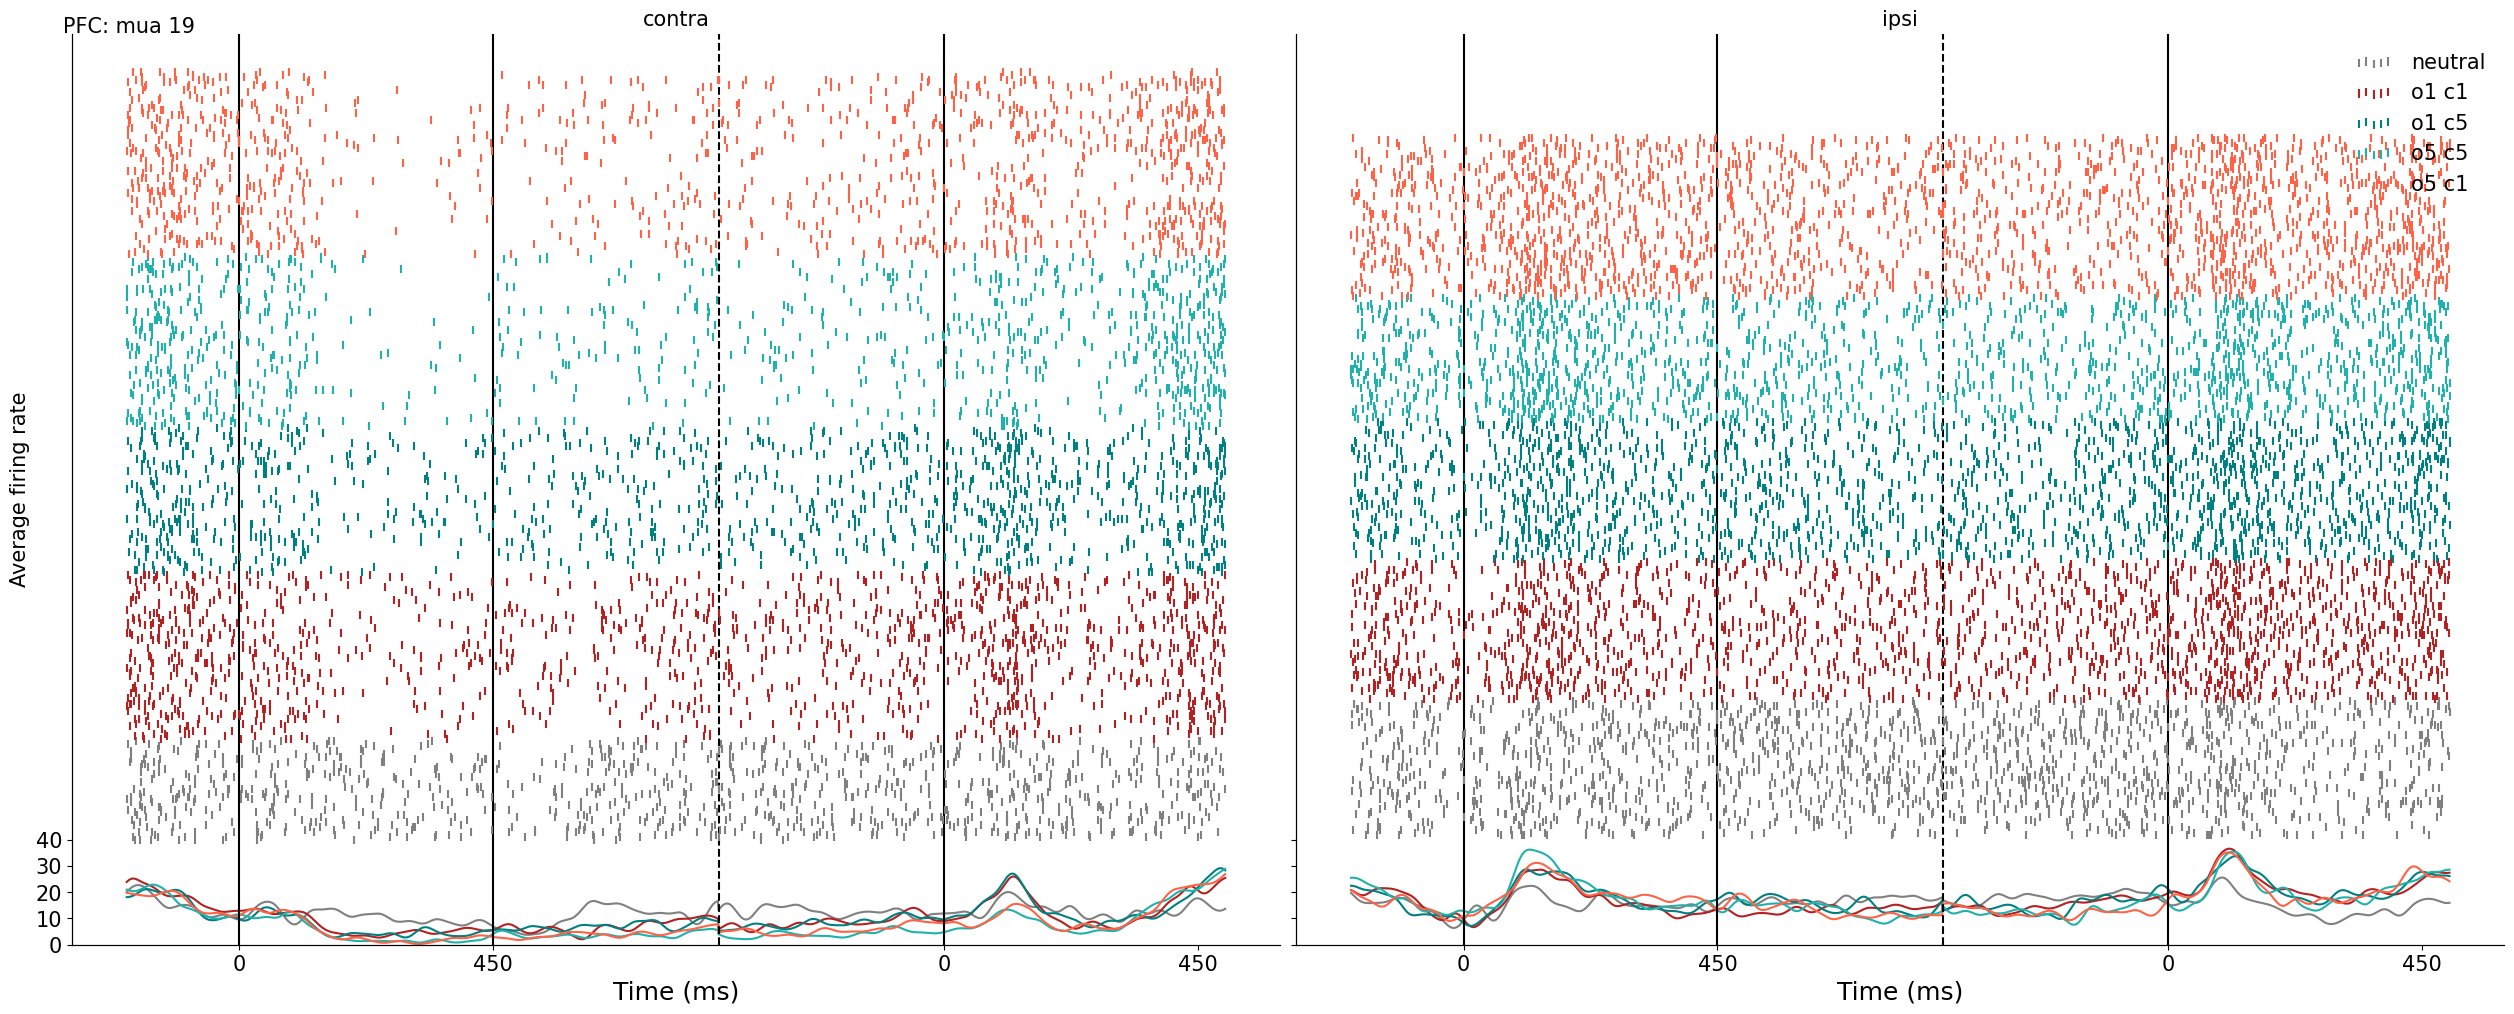

In [15]:
sp, conv = plot_trials.prepare_data_plotb1(neu,rf_stim_loc= ["contra", "ipsi"],cerotr=True,percentile=True)
fig=neu.plot_sp_b1(sp, conv)
#fig.savefig('pp.svg',format='svg')

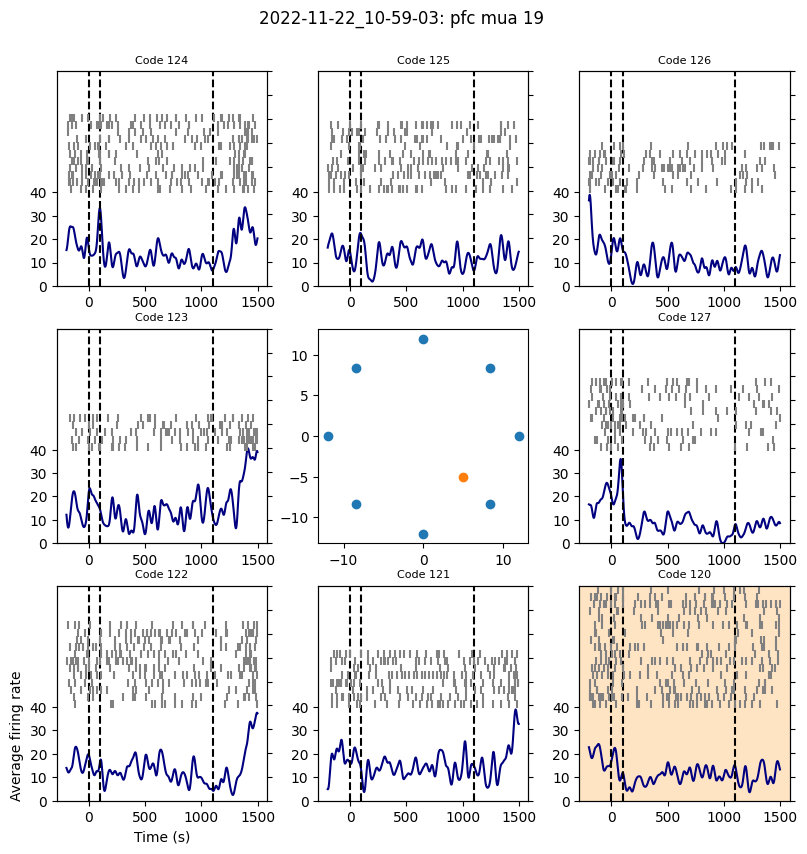

In [16]:
align_sp, alig_mask = neu.align_on(select_block=2,event='target_on',time_before=400,error_type=0)
pos_code = neu.pos_code[alig_mask]
sp_pos = {}
conv_pos = {}
v_resp = {}
conv_all,n_trials = [],[]
for code in np.unique(pos_code):
    code_mask = pos_code == code
    sp_pos[str(int(code))] = align_sp[code_mask][:,200:1900]
    mean_fr = np.mean(align_sp[code_mask],axis=0)[:2100]
    conv_fr = firing_rate.convolve_signal(mean_fr,axis=0)[200:1900]
    conv_pos[str(int(code))] = conv_fr
    conv_all.append(np.max(conv_fr))
    n_trials.append(align_sp[code_mask].shape[0])

max_n_tr = np.max(n_trials)
conv_max = np.max(conv_all)

fig = neu.plot_sp_b2(sp_pos, conv_pos, max_n_tr, conv_max, visual_rf=True,inout=1)

In [17]:
orientation1 = np.concatenate([sp['contra']['11'],sp['contra']['15']],axis=0)
o_avg1 = firing_rate.moving_average(
    orientation1, win=100, step=1
)
orientation5 = np.concatenate([sp['contra']['51'],sp['contra']['55']],axis=0)
o_avg5 = firing_rate.moving_average(
    orientation5, win=100, step=1
)

color1 = np.concatenate([sp['contra']['11'],sp['contra']['51']],axis=0)
c_avg1 = firing_rate.moving_average(
    color1, win=100, step=1
)
color5 = np.concatenate([sp['contra']['15'],sp['contra']['55']],axis=0)
c_avg5 = firing_rate.moving_average(
    color5, win=100, step=1
)

non_neutral = np.concatenate([sp['contra']['15'],sp['contra']['55'],sp['contra']['11'],sp['contra']['51']],axis=0)
non_neutral = firing_rate.moving_average(
    non_neutral, win=100, step=1
)
neutral = sp['contra']['0']
neutral = firing_rate.moving_average(
    neutral, win=100, step=1
)

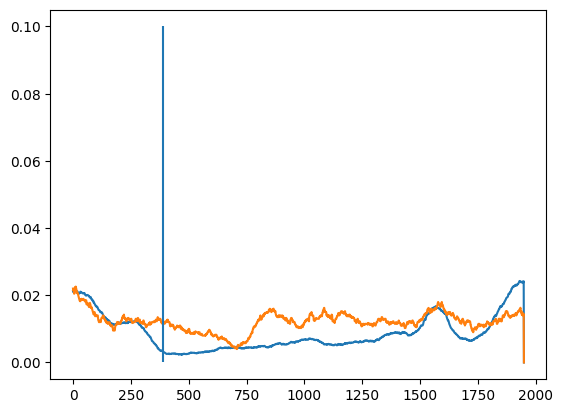

In [18]:
plt.plot(np.mean(non_neutral,axis=0))
plt.plot(np.mean(neutral,axis=0))
plt.vlines(390,0,0.1)

In [19]:
PALETTE_B1 = {
    "11": "firebrick",  # o1_c1
    "15": "teal",  # o1_c5
    "51": "tomato",  # o5_c1
    "55": "lightseagreen",  # o5_c5
    "0": "grey",  # o0_c0
}

In [20]:
non_neutral[:,454]

array([0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.01,
       0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ,
       0.01, 0.01, 0.  , 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.  , 0.01,
       0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.02, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01,
       0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.02, 0.

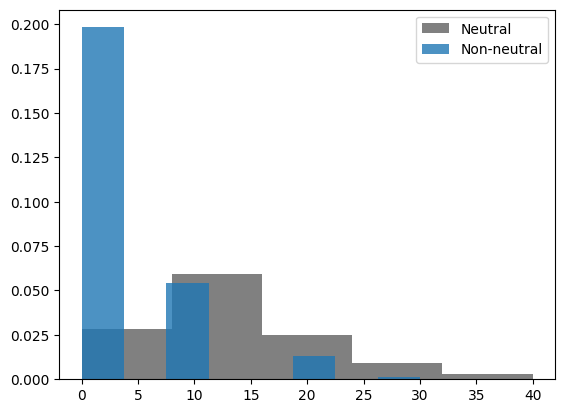

In [21]:
plt.hist(neutral[:,390]*1000,bins=5,color='grey',density=True,label='Neutral')
plt.hist(non_neutral[:,390]*1000,bins=8,density=True, alpha=.8,label='Non-neutral')
plt.legend()


In [22]:
color_lat, color_score, color_p = smetrics.get_selectivity(
    non_neutral, neutral, win=75, scores=True
)

In [23]:
color_lat-200

np.int64(135)

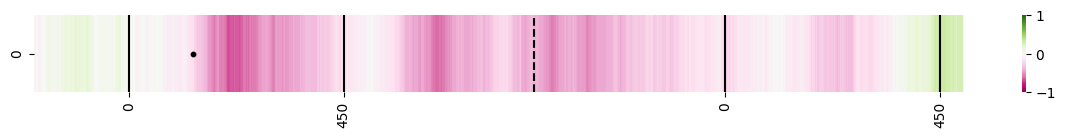

In [24]:
fig,ax=plt.subplots(figsize=(15,1))
sns.heatmap([color_score], vmin=-1, vmax=1, cmap='PiYG',ax=ax)
ax.scatter(color_lat,np.arange(len([color_lat]))+0.5,s=10,color='k')
x_ticks = [200,650,1450,1900]
ax.set_xticks(x_ticks)
ax.set_xticklabels(["0", "450", "0", "450"])

ax.vlines([200,650,1450,1900],ax.get_ylim()[0],ax.get_ylim()[1],'k','-')
ax.vlines([1050],ax.get_ylim()[0],ax.get_ylim()[1],'k','--')